In [73]:
# Import all libraries to be used in this project
import os
from skimage.feature import hog
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from sklearn.svm import LinearSVC
from moviepy.editor import VideoFileClip
from functools import reduce

In [74]:
# Extract images from vehicles 🚗 and non vehicles and return as a list 
def car_images(dir, pattern):
    images = []
    for dirpath, dirnames, filenames in os.walk(dir):
        for dirname in dirnames:
            images.append(glob.glob(dir + '/' + dirname + '/' + pattern))
    flatten = [item for sublist in images for item in sublist]
    return list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), flatten))
cars = car_images('/Users/sambit_panigrahi/Downloads/vehicles', '*.png')
notcars = car_images('/Users/sambit_panigrahi/Downloads/non-vehicles', '*.png')

Vehicle train image count: 8792
Non-vehicle train image count: 8968


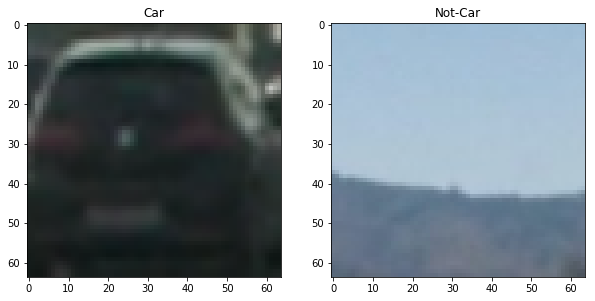

In [75]:
# Print random vehicle and non vehicle images 

vehicle = cars[500]
non_vehicle = notcars[500]

fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
axes[0].imshow(vehicle)
axes[0].set_title('Car')
axes[1].imshow(non_vehicle)
axes[1].set_title('Not-Car')

print('Vehicle train image count: {}'.format(len(cars)))
print('Non-vehicle train image count: {}'.format(len(notcars)))

In [76]:
# From Standard Example : 
# Define a function to compute color histogram features
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# From Standard Example : 
# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# From Standard Example : 
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Value object to hold all feature extraction parameters.
class Parameters():
    def __init__(self):
        # HOG parameters
        self.cspace = 'YCrCb'
        self.orient = 8
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.hog_channel = 'ALL'
        # Bin spatial parameters
        self.size = (16, 16)
        # Histogram parameters
        self.hist_bins = 32
        self.hist_range = (0, 256)
        
def extract_features(image, params ):
    cspace = params.cspace
    orient = params.orient
    pix_per_cell = params.pix_per_cell
    cell_per_block = params.cell_per_block
    hog_channel = params.hog_channel
    size = params.size
    hist_bins = params.hist_bins
    hist_range = params.hist_range
    block_norm='L2-Hys'
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size)

    # Apply color_hist() 
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    
    return np.concatenate((spatial_features, hist_features, hog_features))

In [77]:
# Train using classifier svc

def fitModel( positive, negative, svc, scaler, params ):
    
    positive_features = list(map(lambda img: extract_features(img, params), positive))
    negative_features = list(map(lambda img: extract_features(img, params), negative))
    
    # Create an array stack of feature vectors
    X = np.vstack((positive_features, negative_features)).astype(np.float64)    
    # Fit a per-column scaler
    X_scaler = scaler.fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    y = np.hstack((np.ones(len(positive_features)), np.zeros(len(negative_features))))
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    
    # Fitting
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    
    fittingTime = round(t2 - t, 2)
    accuracy = round(svc.score(X_test, y_test),4)
    return (svc, X_scaler, fittingTime, accuracy)

In [78]:
#Train using images in folder 
params = Parameters()
svc, scaler, fittingTime, accuracy = fitModel(cars, notcars, LinearSVC(), StandardScaler(), params)
print('Time to fit: {} s, Accuracy: {}'.format(fittingTime, accuracy))

Time to fit: 12.28 s, Accuracy: 0.9944


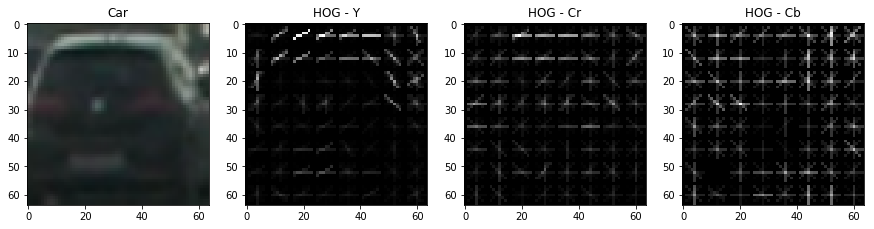

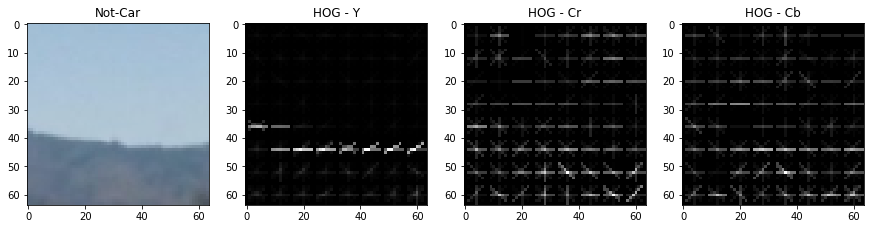

In [79]:
#  Calculate Histogram of Oriented Gradients (HOG) feature extraction on image img 
#  Display vehicles & non vehicles HOG 
def showHOG(img, title):
    img_cspaced = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    _, hog_y = get_hog_features(img_cspaced[:,:,0], 
                                    params.orient, params.pix_per_cell, params.cell_per_block, 
                                    vis=True, feature_vec=True)
    _, hog_Cr = get_hog_features(img_cspaced[:,:,1], 
                                    params.orient, params.pix_per_cell, params.cell_per_block, 
                                    vis=True, feature_vec=True)
    _, hog_Cb = get_hog_features(img_cspaced[:,:,2], 
                                    params.orient, params.pix_per_cell, params.cell_per_block, 
                                    vis=True, feature_vec=True)

    fig, axes = plt.subplots(ncols=4, figsize=(15,15))
    axes[0].imshow(img)
    axes[0].set_title(title)
    axes[1].imshow(hog_y, cmap='gray')
    axes[1].set_title('HOG - Y')
    axes[2].imshow(hog_Cr, cmap='gray')
    axes[2].set_title('HOG - Cr')
    axes[3].imshow(hog_Cb, cmap='gray')
    axes[3].set_title('HOG - Cb')

showHOG(vehicle, 'Car')
showHOG(non_vehicle, 'Not-Car')


In [80]:
# Standard Example for drawing boxes: 
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

# Function to generate sliding windows 
def slide(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))

    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 

    window_list = []

    
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
            
    return window_list

In [81]:
test_images = list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), glob.glob('./test_images/*.jpg')))

In [82]:
# Within sliding window, search for cars, and return windows where cars are found.
#Returns a new image with the cars boxes
def Search(img, clf, scaler, params, y_start_stop=[360, 700], xy_window=(64, 64), xy_overlap=(0.85, 0.85) ):
    car_windows = []
    windows = slide(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    for window in windows:
        img_window = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = extract_features(img_window, params)
        scaled_features = scaler.transform(features.reshape(1, -1))
        pred = clf.predict(scaled_features)
        if pred == 1:
            car_windows.append(window)
    return car_windows

# draw the boxes which found cars on the sliding windows 
def drawCars(img, windows):
    output = np.copy(img)
    return draw_boxes(output, windows)

In [83]:
car_on_test = list(map(lambda img: drawCars(img, Search(img, svc, scaler, params)), test_images))

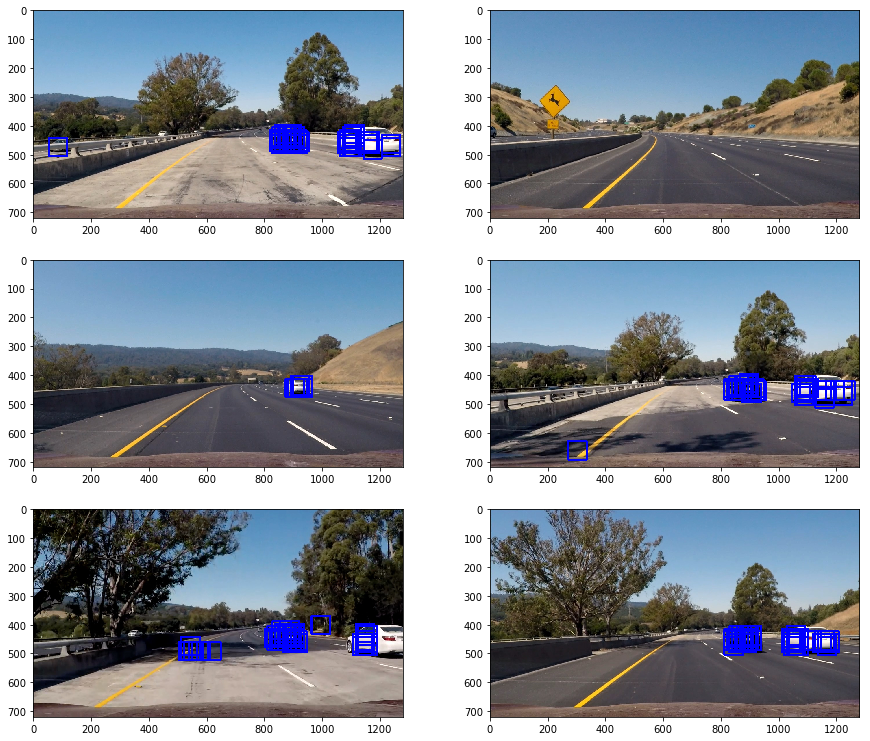

In [84]:
def showImages(images, cols = 2, rows = 3, figsize=(15,13)):

    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            image = images[index]
            ax.imshow(image)
            
showImages(car_on_test)

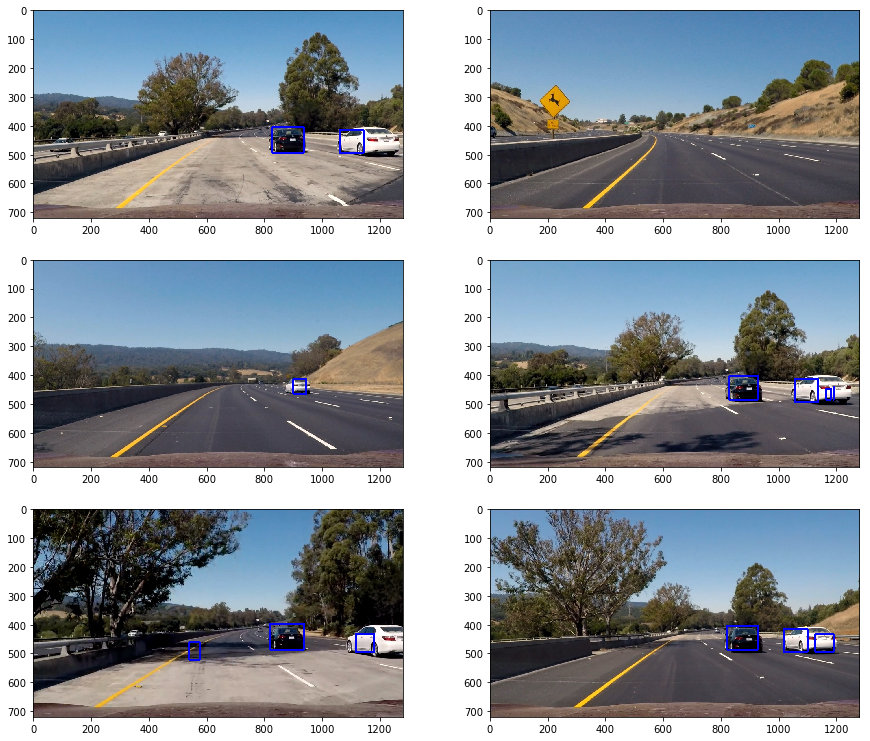

In [85]:
# Standard Example 

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

from scipy.ndimage.measurements import label

def drawCarsWithLabels(img, boxes, threshHold = 4):
    
    heatmap = add_heat(np.zeros(img.shape), boxes)
    heatmap = apply_threshold(heatmap, threshHold)
    labels = label(heatmap)
    
    return draw_labeled_bboxes(np.copy(img), labels)
    
boxed_on_test = list(map(lambda img: drawCarsWithLabels(img, Search(img, svc, scaler, params)), test_images))

showImages(boxed_on_test)

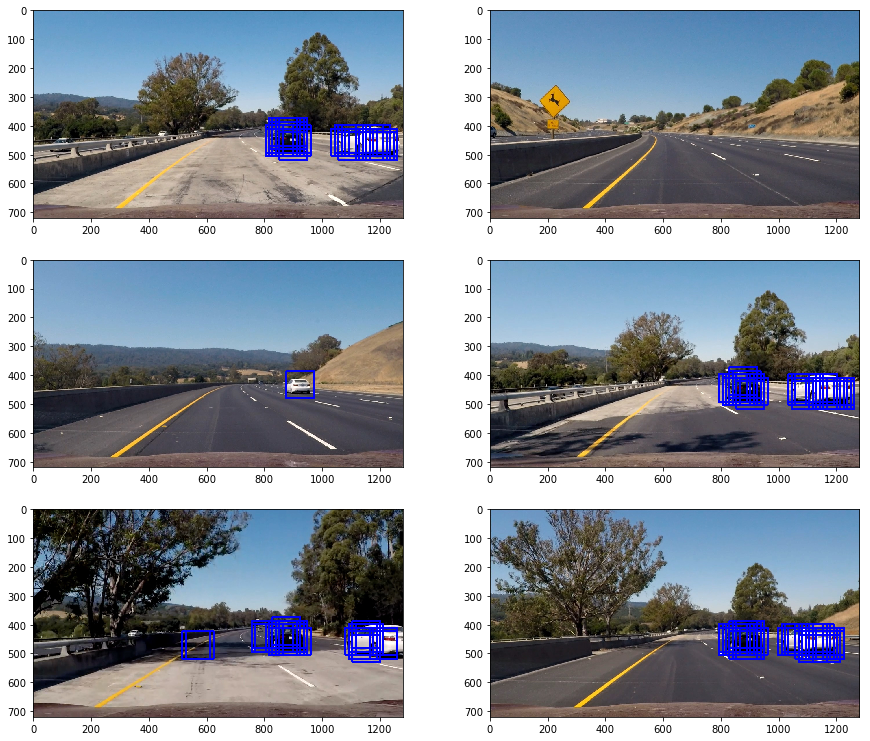

In [86]:
# Find boxes, and return windows where cars are found on the image. 
# Function returns a new image with the cars boxes. 
def findBoxes(img, clf, scaler, params, y_start_stop=[350, 656], window=64, cells_per_step=1, scale=1.5 ):

    cspace = params.cspace
    orient = params.orient
    pix_per_cell = params.pix_per_cell
    cell_per_block = params.cell_per_block
    hog_channel = params.hog_channel
    size = params.size
    hist_bins = params.hist_bins
    hist_range = params.hist_range
    
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    
    ystart, ystop = y_start_stop
    search = feature_image[ystart:ystop,:,:]
    if scale != 1:
        imshape = search.shape
        search = cv2.resize(search, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = search[:,:,0]
    ch2 = search[:,:,1]
    ch3 = search[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    car_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            subimg = cv2.resize(search[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            spatial_features = bin_spatial(subimg, size=size)
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)
            
            test_features = scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return car_windows

fast_boxes = list(map(lambda img: findBoxes(img, svc, scaler, params), test_images))

fast_on_test = list(map(lambda imgAndBox: drawCars(imgAndBox[0], imgAndBox[1]), zip(test_images, fast_boxes)))

showImages(fast_on_test)

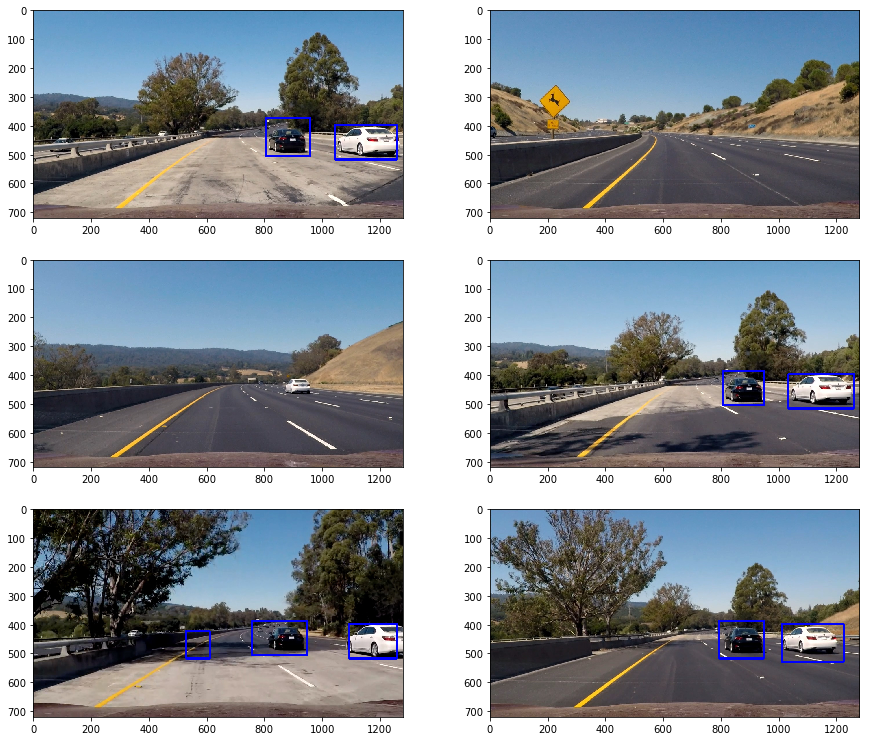

In [87]:
fast_on_test = list(map(lambda imgAndBox: drawCarsWithLabels(imgAndBox[0], imgAndBox[1], threshHold=1), zip(test_images, fast_boxes)))
showImages(fast_on_test)

In [88]:
class History():
    def __init__(self):
        self.history = []

def video_piepline(inputVideo, outputVideo, frames_to_remember=3, threshhold=1):
    history = History()

    def pipeline(img):
        boxes = findBoxes(img, svc, scaler, params)
        img_shape = img.shape
        heatmap = add_heat(np.zeros(img_shape), boxes)
        if len(history.history) >= frames_to_remember:
            history.history = history.history[1:]
            
        history.history.append(heatmap)
        heat_history = reduce(lambda h, acc: h + acc, history.history)/frames_to_remember
        heatmap = apply_threshold(heat_history, threshhold)
        labels = label(heatmap)
        return draw_labeled_bboxes(np.copy(img), labels)

    myclip = VideoFileClip(inputVideo)
    output_video = myclip.fl_image(pipeline)
    output_video.write_videofile(outputVideo, audio=False)
    
video_piepline('./project_video.mp4', './output_project_video.mp4', threshhold=2)

[MoviePy] >>>> Building video ./output_project_video.mp4
[MoviePy] Writing video ./output_project_video.mp4


100%|█████████▉| 1260/1261 [25:26<00:00,  1.03it/s]  


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_project_video.mp4 

